# Your First RAG Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAG application.

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.11.4.

> NOTE: There might be [compatibility issues](https://github.com/wandb/wandb/issues/7683) if you're on NVIDIA driver >552.44 As an interim solution - you can rollback your drivers to the 552.44.

## Table of Contents:

- Task 1: Imports and Utilities
- Task 2: Documents
- Task 3: Embeddings and Vectors
- Task 4: Prompts
- Task 5: Retrieval Augmented Generation
  - 🚧 Activity #1: Augment RAG

Let's look at a rather complicated looking visual representation of a basic RAG application.

<img src="https://i.imgur.com/vD8b016.png" />

In [7]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 42.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 17.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 29.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 76.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 67.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.3

In [28]:
import os
from typing import List
from sentence_transformers import SentenceTransformer, util
import numpy as np
import nltk

class SemanticTextSplitter:
    def __init__(
        self,
        similarity_threshold: float = 0.75,
        model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
        max_chunk_size: int = 1000,
    ):
        """
        :param similarity_threshold: The minimum average similarity 
                                     to keep sentences in the same chunk.
        :param model_name: SentenceTransformers model name.
        :param max_chunk_size: Maximum chunk size (in characters) 
                               before starting a new chunk (optional).
        """
        self.similarity_threshold = similarity_threshold
        self.model = SentenceTransformer(model_name)
        self.max_chunk_size = max_chunk_size

    def tokenize_text(self, text: str) -> List[str]:
        """
        Splits text into sentences or paragraphs. 
        For simplicity, we use sentence tokenization here.
        """
        # You could also split by paragraphs or any custom rules
        sentences = nltk.sent_tokenize(text)
        return sentences

    def embed_sentences(self, sentences: List[str]) -> np.ndarray:
        """
        Returns the embeddings for a list of sentences.
        """
        return self.model.encode(sentences, convert_to_tensor=True).to('cpu')

    def split(self, text: str) -> List[str]:
        """
        Splits a single text into semantically coherent chunks.
        """
        # 1. Sentence-level split
        sentences = self.tokenize_text(text)
        # 2. Embed each sentence
        sentence_embeddings = self.embed_sentences(sentences)

        chunks = []
        current_chunk = []
        current_chunk_embeddings = []

        current_chunk_size = 0  # track character length of chunk

        for idx, sentence in enumerate(sentences):
            sentence_embedding = sentence_embeddings[idx]

            if not current_chunk:
                # start the first chunk
                current_chunk.append(sentence)
                current_chunk_embeddings.append(sentence_embedding)
                current_chunk_size += len(sentence)
            else:
                # check similarity with the current chunk's centroid
                centroid = np.mean(current_chunk_embeddings, axis=0)
                similarity = float(util.cos_sim(centroid, sentence_embedding))

                new_size = current_chunk_size + len(sentence)

                # If similarity is high enough (and not exceeding max chunk size),
                # add to current chunk
                if similarity >= self.similarity_threshold and new_size <= self.max_chunk_size:
                    current_chunk.append(sentence)
                    current_chunk_embeddings.append(sentence_embedding)
                    current_chunk_size = new_size
                else:
                    # Otherwise, start a new chunk
                    chunks.append(" ".join(current_chunk))
                    current_chunk = [sentence]
                    current_chunk_embeddings = [sentence_embedding]
                    current_chunk_size = len(sentence)

        # Add the last chunk if it exists
        if current_chunk:
            chunks.append(" ".join(current_chunk))

        return chunks

    def split_texts(self, texts: List[str]) -> List[str]:
        """
        Splits multiple texts into semantically coherent chunks.
        """
        all_chunks = []
        for text in texts:
            all_chunks.extend(self.split(text))
        return all_chunks


## Task 1: Imports and Utility

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [29]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
import asyncio

In [30]:
import nest_asyncio
nest_asyncio.apply()

## Task 2: Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

### Loading Source Documents

So, first things first, we need some documents to work with.

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format.

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.


In [31]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/8s/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [106]:
with open("data/PMarcaBlogs.txt", "r") as f:
    the_text = f.read()
    the_text = the_text[:1000000]
    print("the_text", len(the_text))

splitter = SemanticTextSplitter(similarity_threshold=0.25, max_chunk_size=3000)
split_documents = splitter.split(the_text)

# = text_loader.load_documents()
print("split_documents:", len(split_documents))

the_text 297904
split_documents: 970


In [107]:
print(split_documents[200])

“My God!


### Splitting Text Into Chunks

As we can see, there is one massive document.

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM.

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length.

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following:
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

As you can imagine (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

## Task 3: Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format as we explored in the Embedding Primer notebook.

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

### OpenAI API Key

In order to access OpenAI's APIs, we'll need to provide our OpenAI API Key!

You can work through the folder "OpenAI API Key Setup" for more information on this process if you don't already have an API Key!

In [97]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

### Vector Database

Let's set up our vector database to hold all our documents and their embeddings!

While this is all baked into 1 call - we can look at some of the code that powers this process to get a better understanding:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model.

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓Question #1:

The default embedding dimension of `text-embedding-3-small` is 1536, as noted above. 

1. Is there any way to modify this dimension?
> Yes!  According to the documentation you can supply a parameter 'dimensions' to the API call that will govern how many dimensions the embedding has.


2. What technique does OpenAI use to achieve this?
> It's using a technique called Matryoshka Representation!
> It produces representations that can be adjusted to different sizes without loss in accuracy.
> Coarse representations suffice for simpler tasks, while fine-grained layers are used for more complex tasks.

> NOTE: Check out this [API documentation](https://platform.openai.com/docs/api-reference/embeddings/create) for the answer to question #1, and [this documentation](https://platform.openai.com/docs/guides/embeddings/use-cases) for an answer to question #2!

We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [98]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### ❓Question #2:

What are the benefits of using an `async` approach to collecting our embeddings?
>> By using async, we don't need to wait to get the embeddings for a single document before we launch the api call to get the embedding of the next document.

> NOTE: Determining the core difference between `async` and `sync` will be useful! If you get stuck - ask ChatGPT!

So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus.

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [99]:
vector_db.search_by_text("What is the Michael Eisner Memorial Weak Executive Problem?", k=3)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[('The CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive. I call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place.',
  np.float64(0.7251383786920761)),
 ('When hiring and when Hring executives, you\nmust therefore focus on strength rather than lack of weakness. Everybody has severe weaknesses even if you can’t see\nthem yet. When managing, it’s oaen useful to micromanage and\nto provide remedial training around these weaknesses. Doing so\nmay make the diWerence between an executive succeeding or\nfailing. For example, you might have a brilliant engineering executive\nwho generates excellent team loyalty, has terriXc product judgment and makes the trains run on time.

## Task 4: Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work.

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)):

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this:

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts.

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-4o-mini"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓ Question #3:

When calling the OpenAI API - are there any ways we can achieve more reproducible outputs?

> Parameters like temperature can reduce randomness, but cannot gaurtuntee reproducible outputs
> I see a parameter named "seed" in the docs, but it's marked as beta and not garunteed to work.  It says that combined with system_fingerprint, it's possible to start to appraoch some determanism for our outputs.

This was really interesting (more on system_fingerprint):
https://platform.openai.com/docs/api-reference/completions/object#completions/object-system_fingerprint

> NOTE: Check out [this section](https://platform.openai.com/docs/guides/text-generation/) of the OpenAI documentation for the answer!

### Creating and Prompting OpenAI's `gpt-4o-mini`!

Let's tie all these together and use it to prompt `gpt-4o-mini`!

In [100]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    system_role_prompt.create_message(expertise="Python"),
    user_role_prompt.create_message(
        content="What is the best way to write a loop?"
    ),
]

response = chat_openai.run(messages)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [101]:
print(response)

The best way to write a loop in Python depends on what you're trying to achieve, but I can share some general practices that are commonly followed for clarity and efficiency.

### 1. Using `for` Loops
`for` loops are ideal for iterating over items in a collection (like a list, tuple, or string).

```python
# Example of a for loop
fruits = ['apple', 'banana', 'cherry']
for fruit in fruits:
    print(fruit)
```

### 2. Using `while` Loops
`while` loops are useful when you need to repeat an action until a certain condition is met.

```python
# Example of a while loop
count = 0
while count < 5:
    print(count)
    count += 1  # Don't forget to update the condition!
```

### 3. Avoiding Infinite Loops
Always ensure that your loop will eventually stop running. For example, in a `while` loop, make sure to update the condition.

### 4. Using `enumerate()` with `for` Loops
If you need both the index and the value from a list, use `enumerate()`.

```python
# Example with enumerate
for index, fr

## Task 5: Retrieval Augmented Generation

Now we can create a RAG prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [102]:
RAG_PROMPT_TEMPLATE = """ \
Use the provided context to answer the user's query.

You may not answer the user's query unless there is specific context in the following text.

If you do not know the answer, or cannot answer, please respond with "I don't know".
"""

rag_prompt = SystemRolePrompt(RAG_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""


user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=4)

        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = rag_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)

        return {"response" : self.llm.run([formatted_system_prompt, formatted_user_prompt]), "context" : context_list}

#### ❓ Question #4:

What prompting strategies could you use to make the LLM have a more thoughtful, detailed response?

Stategies:
>Prompt: "think through it's answer step by step before answering."

>Prompt: "Organize your thoughts into an outline before printing your final answer,"

Give some examples of outputs.  Possibly even some examples of how to use rag.

What is that strategy called?
> This stategy is called prompt engineering!

> NOTE: You can look through the Week 1 Day 1 "Prompting OpenAI Like A Developer" material for an answer to this question!

In [103]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

In [104]:
retrieval_augmented_qa_pipeline.run_pipeline("What is the 'Michael Eisner Memorial Weak Executive Problem'?")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'response': "The 'Michael Eisner Memorial Weak Executive Problem' refers to the tendency of CEOs with backgrounds in specific areas (such as product management, sales, or marketing) to hire executives for those same areas who may not be strong performers. An example is given about Michael Eisner, the former CEO of Disney, who, despite being an excellent TV network executive, oversaw a decline in ABC's performance after acquiring it. This problem highlights the importance of focusing on the strengths of executives when hiring, rather than merely the absence of weaknesses, as everyone has severe weaknesses that may not be immediately apparent.",
 'context': [('The CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive. I call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previousl

### 🏗️ Activity #1:

Enhance your RAG application in some way! 

Suggestions are: 

- Allow it to work with PDF files
- Implement a new distance metric
- Add metadata support to the vector database

While these are suggestions, you should feel free to make whatever augmentations you desire! 

> NOTE: These additions might require you to work within the `aimakerspace` library - that's expected!

In [105]:
#Done!   
# I changed the text chunking strategy to chunk by semantic meaning.  
# You can find the semantic chunker above ^^^
# I'm sure there are more elegant ways to do it, but I wanted to try a very rough & hands on way first & see what would happen!
# So far, it seems to work pretty well!

My own RAG Diagram!
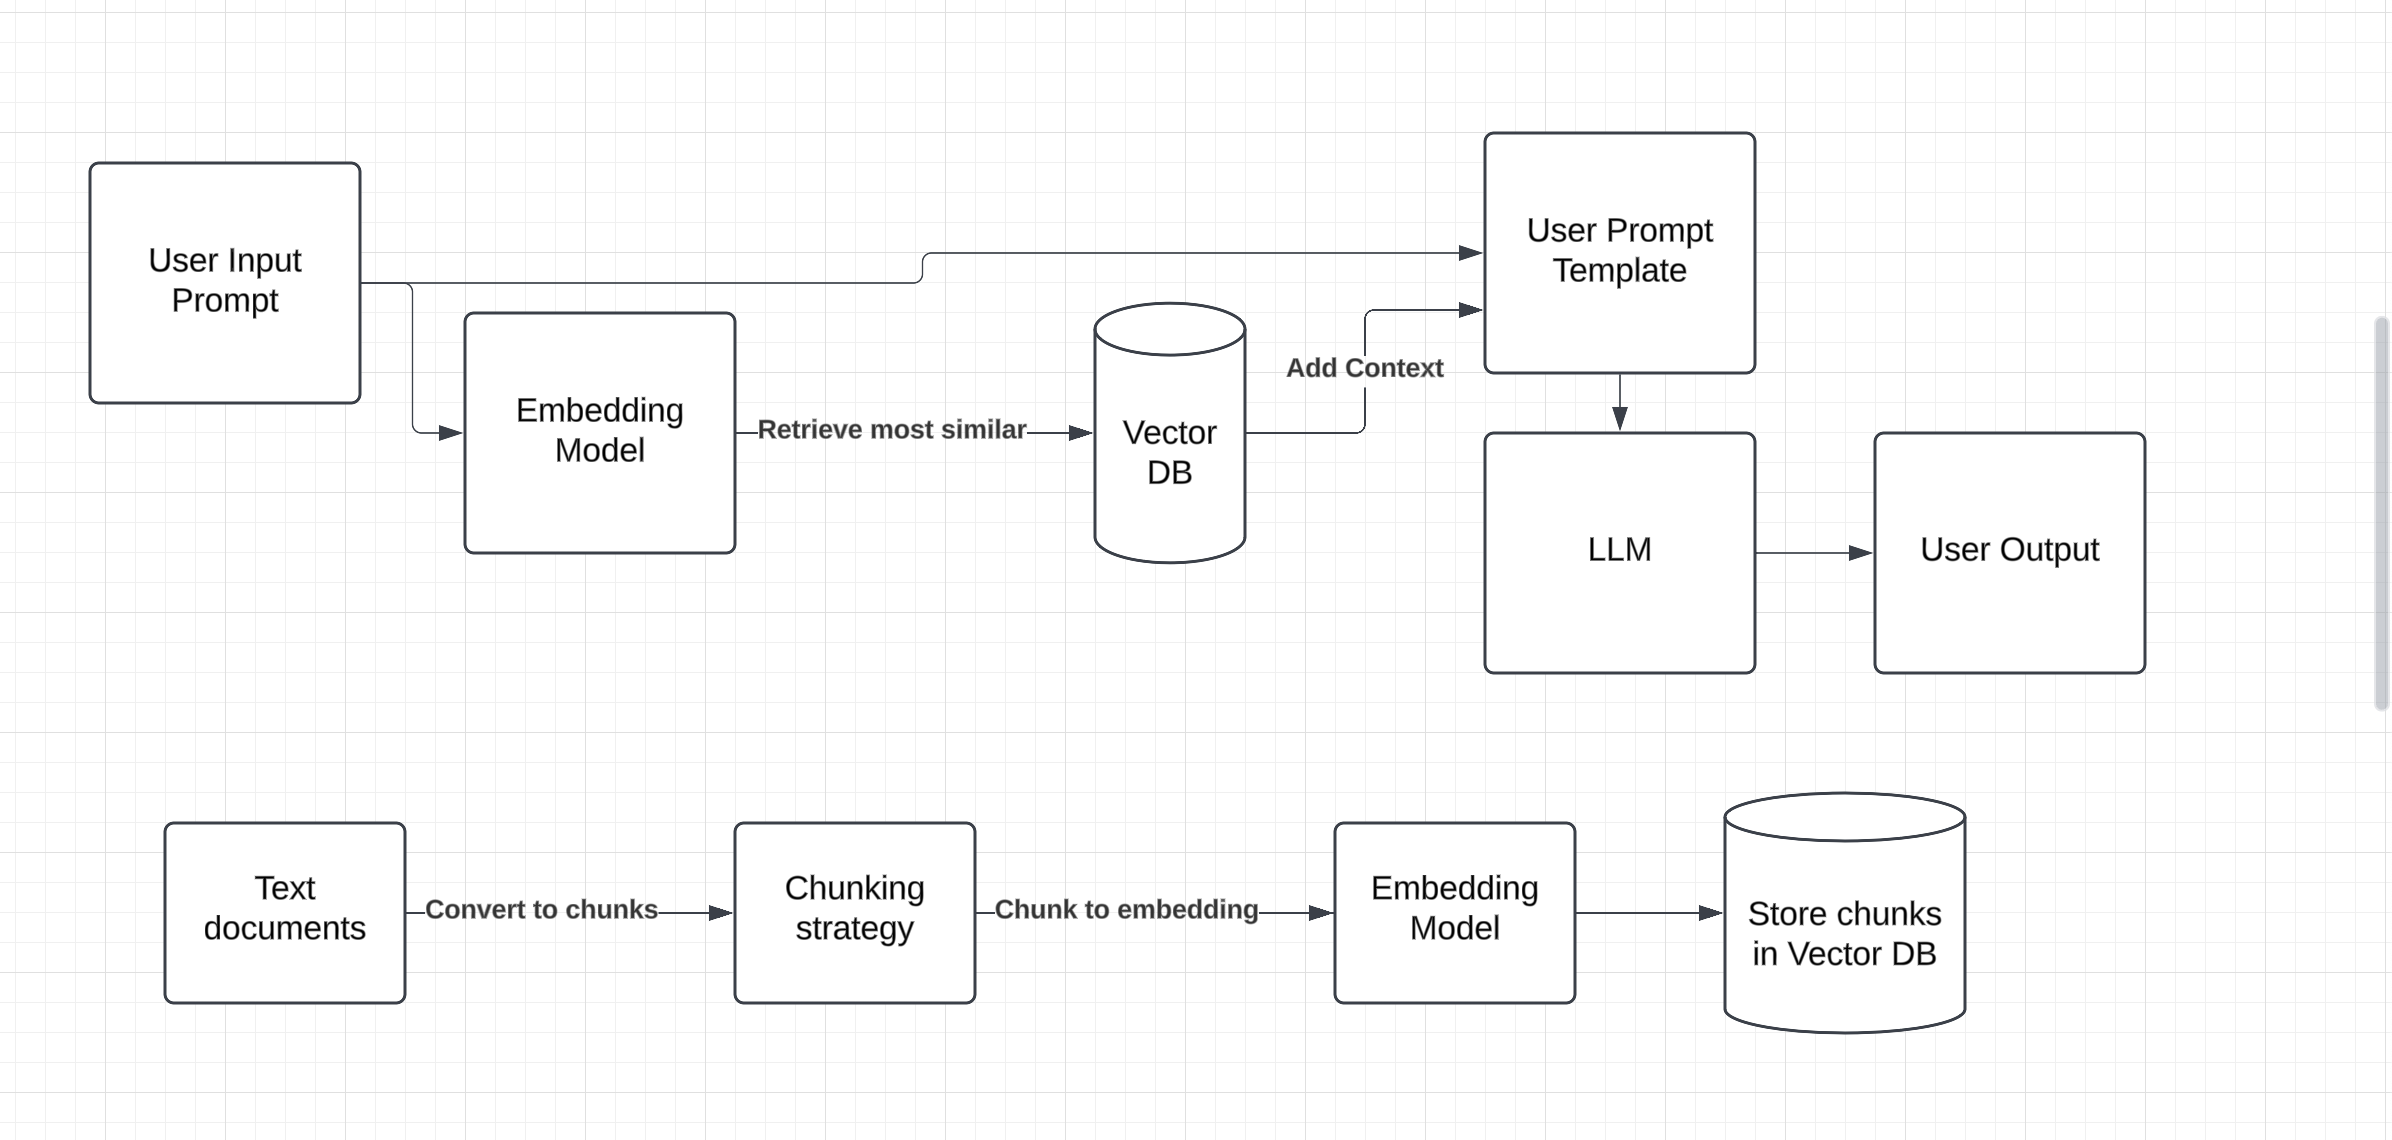

https://lucid.app/lucidchart/520de185-4880-4960-9fa5-f03f1a0209e7/edit?viewport_loc=3%2C-45%2C1601%2C844%2C0_0&invitationId=inv_6c954e01-a978-4a3e-85ec-a58a601becad